<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Decision Trees and Ensemble methods

---

## What is a Random Forest?

---

Random Forests are some of the most widespread classifiers used. They are relatively simple to use because they require very few parameters to set and they perform well. As we have seen, Decision Trees are very powerful machine learning models.

Decision Trees have some critical limitations. In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets. Bagging helps mitigate this problem by exposing different trees to different sub-samples of the whole training set.

Random forests are a further way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.

### Feature bagging

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is sometimes called feature bagging. 

The reason for doing this is due to correlation of trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the bagging base trees, causing them to become correlated. By selecting a random subset of the features at each split, we avoid this correlation between base trees, strengthening the overall model.

#### For a problem with p features, it is typical to use:
- $p^{1/2}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.


#### Sklearn implementation
- [Sklearn Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
- [Sklearn Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

### 1. Load the Boston housing data set

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print((boston.data.shape))

(506, 13)


In [3]:
list(boston.keys())

['data', 'target', 'feature_names', 'DESCR']

In [4]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [6]:
X = pd.DataFrame(boston['data'], columns=boston.feature_names)
y = pd.DataFrame(boston.target)

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### 2. Split into train and test sets and rescale the data with the standard scaler 

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=boston.feature_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=boston.feature_names)

y_train = scaler.fit_transform(y_train)
y_train.shape = (len(y_train),)

y_test = scaler.transform(y_test)
y_test.shape = (len(y_test),)

In [10]:
y_train.shape, y_test.shape

((404,), (102,))

In [11]:
pd.Series(y_train).describe()

count    4.040000e+02
mean     3.484561e-16
std      1.001240e+00
min     -1.909378e+00
25%     -6.272709e-01
50%     -1.283754e-01
75%      3.866134e-01
max      2.918642e+00
dtype: float64

In [12]:
pd.Series(y_test).describe()

count    102.000000
mean      -0.140367
std        0.923311
min       -1.909378
25%       -0.608495
50%       -0.283945
75%        0.137166
max        2.918642
dtype: float64

### 3. Fit the data using a decision tree regressor on the training data and obtain mean squared and r2 error for the test set for a maximal tree depth of three.

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = DecisionTreeRegressor(max_depth=3, random_state=1)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('Training error: ')
print('MSE: ', mean_squared_error(y_train, model.predict(X_train)))
print('R2: ', r2_score(y_train, model.predict(X_train)))

print('Test error: ')
print('MSE: ', mean_squared_error(y_test, predictions))
print('R2: ', r2_score(y_test, predictions))

Training error: 
MSE:  0.18382195774373053
R2:  0.8161780422562694
Test error: 
MSE:  0.15545546752694975
R2:  0.8158427804142424


### 4. Visualise the corresponding decision tree

In [14]:
from os import system
from sklearn.tree import export_graphviz


def build_tree_image(model, filename='tree.png'):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file=dotfile, feature_names=X.columns, filled=True,
                    rounded=True, special_characters=True)
    dotfile.close()
    # comment out this line if you don't have GraphViz yet
    system("dot -Tpng tree.dot -o {0}".format(filename))

In [15]:
build_tree_image(model, 'tree.png')

<img src='../tree.png' width = 80%>

### 5. Perform grid search varying the maximal tree depth, the maximal number of leaf nodes and the minimal number of samples in the leafs. Determine the best model using once the default R2 scoring and once 'neg_mean_squared_error' and compare.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
kfolds = 5
model = DecisionTreeRegressor(random_state=1)
# Grid Search
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          #, 'max_features':[1,2,3,4],
          'max_leaf_nodes': [5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4]
          #'min_samples_split':[1,2,3,4]
          }

gs = GridSearchCV(model, param_grid=params, cv=kfolds)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 test: ', gs.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=9, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R2 training:  0.8492226108881178
R2 test:  0.8088669826285886


In [18]:
gs_mse = GridSearchCV(model, param_grid=params, cv=kfolds,
                      scoring='neg_mean_squared_error')
gs_mse.fit(X_train, y_train)

print(gs_mse.best_estimator_)
print('MSE training: ', -gs_mse.score(X_train, y_train))
print('MSE test: ', -gs_mse.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=9, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
MSE training:  0.15077738911188218
MSE test:  0.1613440550533121


### 6. Now use ensemble methods to fit decision trees. For BaggingRegressor and RandomForestRegressor, vary the number of estimators (`n_estimators`). Use cross_val_score with five-fold cross validation and scoring `neg_mean_squared_error`. Plot how the mean of the scoring changes.

In [19]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [20]:
def do_cross_val(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, n_jobs=1,
                             scoring='neg_mean_squared_error')
    # , scores.std()#, cross_val_score(model, X, y, cv=5, n_jobs=1).mean()
    return -scores.mean()

In [21]:
values = sorted(
    list(set(np.logspace(0, 3, num=20, endpoint=True, base=10.0).astype(int))))

In [22]:
score_list = []
for n in values:
    models = [('Bagging', BaggingRegressor(random_state=1, n_estimators=n)),
              ('RandomForest', RandomForestRegressor(
                  random_state=1, n_estimators=n))
              ]
    for model in models:
        model[1].fit(X_train, y_train)
        train_score_cv = do_cross_val(model[1], X_train, y_train)
        train_predictions = model[1].predict(X_train)
        test_predictions = model[1].predict(X_test)
        train_score = mean_squared_error(y_train, train_predictions)
        test_score = mean_squared_error(y_test, test_predictions)
        score_list.append(
            [model[0], n, train_score_cv, train_score, test_score])

In [23]:
df_scores = pd.DataFrame(score_list, columns=[
                         'model', 'estimators', 'train_mse_cv', 'train_mse', 'test_mse'])
df_scores.head()

,model,estimators,train_mse_cv,train_mse,test_mse
0,Bagging,1,0.289277,0.119057,0.324034
1,RandomForest,1,0.273247,0.109229,0.318262
2,Bagging,2,0.227129,0.053770,0.138930
3,RandomForest,2,0.228223,0.056443,0.112455
4,Bagging,4,0.183094,0.032618,0.130991


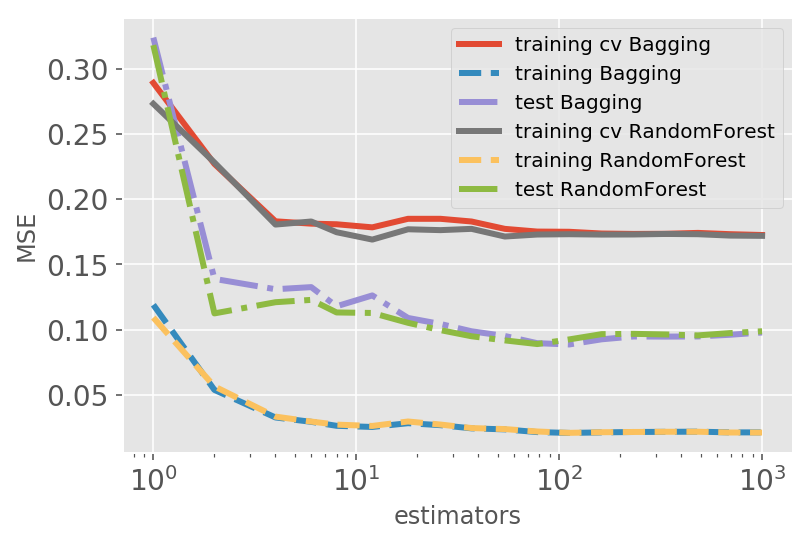

In [24]:
groups = df_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='train_mse_cv', ax=ax,
                                 label='training cv '+group, lw=3, fontsize=14, logx=True)
    groups.get_group(group).plot(x='estimators', y='train_mse', ax=ax,
                                 label='training '+group, lw=3, ls='--', fontsize=14, logx=True)
    groups.get_group(group).plot(x='estimators', y='test_mse', ax=ax,
                                 label='test ' + group, lw=3, ls='-.', fontsize=14, logx=True)

plt.ylabel('MSE')
plt.show()

### Bonus: Vary further parameters and describe the impact on the model score.

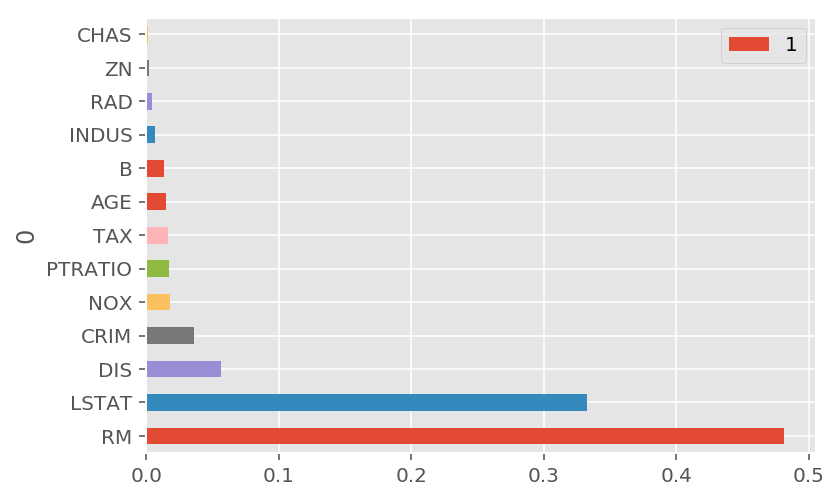

In [25]:
pd.DataFrame(list(zip(X_train.columns,model[1].feature_importances_))).sort_values(by=1,ascending=False).plot(kind='barh',
    x=0,y=1)
plt.show()